# Load dependencies

In [1]:
#BiocManager::install("GenomicRanges")
#BiocManager::install("ChIPseeker")
#BiocManager::install("EnsDb.Hsapiens.v86")
#BiocManager::install("org.Hs.eg.db")
#BiocManager::install("clusterProfiler")
#BiocManager::install("UpSetR")
#BiocManager::install("ReactomePA")
#BiocManager::install("liftOver")
#BiocManager::install("genomation")

In [3]:
working_directory="~/stochastic_regulation_code/accessory_files/"

In [4]:
library(tidyverse)
library(GenomicRanges)
library(ChIPseeker)
library(rtracklayer)
library(EnsDb.Hsapiens.v86)
ensdb <- EnsDb.Hsapiens.v86
library(org.Hs.eg.db)
library(clusterProfiler)
library(UpSetR)
library(ReactomePA)
library(liftOver)
library(genomation)
source(paste(working_directory,"JuicerUtilities.R",sep=""))
`%notin%` <- Negate(`%in%`)

Read correlation files

In [5]:
corr.data.all <- read_csv(paste(working_directory,"correlations_JL_011_no_doublets_total_TF_total_target_considering_cell_cycle_FALSE_10^6_iterations.csv",sep=""))


New names:
• `` -> `...1`
Rows: 2856169 Columns: 32
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): TF, target
dbl (24): ...1, rho_0hr, p.value0hr, q_value_0hr, rho_2hr, p.value2hr, q_val...
lgl  (6): needs_more_permut_0hr, needs_more_permut_2hr, needs_more_permut_4h...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
## Read metadata                                 
chip.dir <- paste(working_directory,"ENCODE",sep="")

seqlevelsStyle(ensdb) <- "UCSC"

#meta <- read.table("ChIP/metadata_bed.tsv",header=T,sep="\t")
#meta <- as_tibble(meta)
#meta$tf <- str_split(meta$Experiment.target,"-",simplify=T)[,1]
#meta.filtered <- dplyr::filter(meta, Output.type == 'conservative IDR thresholded peaks' & File.analysis.status == 'released' &  & !grepl("insufficient",Audit.NOT_COMPLIANT))
#meta.filtered$file.name <- with(meta.filtered,paste0(chip.dir,tf,"_",File.accession,".bed.gz"))
#write_delim(meta.filtered,"ChIP/meta_filtered_tfs.txt")
#meta.our.filtered <- meta.filtered %>% dplyr::filter(tf %in% corr.data.all$TF)
#writeTable(meta.our.filtered,"ChIP/meta_our_tfs_v2.txt")

meta.filtered <- read_tsv(paste(working_directory,"/meta_our_tfs_v2.txt",sep=""))


Rows: 246 Columns: 59
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (38): File.accession, File.format, File.type, File.format.type, Output.t...
dbl  (1): Size
lgl (20): Biosample.treatments, Biosample.treatments.amount, Biosample.treat...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [8]:
## Download ENCODE data
#for (i in seq_along(meta.filtered$tf)) with(meta.filtered,download.file(File.download.URL[i],destfile=paste0(chip.dir,tf[i],"_",File.accession[i],".bed.gz"),method="wget"))

## Load ABC data
#ABC <- read_tsv("ChIP/AllPredictions.AvgHiC.ABC0.015.minus150.ForABCPaperV3.txt")
#abc.gr <- makeGRangesFromDataFrame(ABC,ignore.strand=T,keep.extra.columns=T)
abc.gr <- readGeneric(paste(working_directory,"ABC.hg38.txt",sep=""), header=T, keep.all.metadata=T)
#abc.k562.gr <- readGeneric("ChIP/ABC_K562.hg38.txt", header=T, keep.all.metadata=T)

abc.k562.gr <- abc.gr[abc.gr$CellType=="K562-Roadmap"]
#mcols(abc.k562.gr) <- as_tibble(mcols(abc.k562.gr)) %>% left_join(as_tibble(ensembldb::select(ensdb,keys=abc.k562.gr$TargetGene,columns=c("GENENAME","GENEID","ENTREZID","SEQSTRAND"),keytype="SYMBOL")),by=c("TargetGene"="SYMBOL"))
#abc.hg38.gr <- readGeneric("ChIP/ABC_K562.hg38.bed", header=F, meta.col=list(name2=4))
#mcols(abc.hg38.gr) <- as.data.frame(as_tibble(mcols(abc.k562.gr)) %>% right_join(as_tibble(mcols(abc.hg38.gr)),by="name2"))

#promoter.gr <- promoters(ensdb,2000,2000)

tf.enrich <- meta.filtered %>% dplyr::select(tf,File.accession) %>% add_column(odds.ratio=NA, odds.ratio.filt=NA, odds.ratio.filt2=NA, enrich.p=NA, enrich.p.filt=NA, enrich.p.filt2=NA,conf.int.low=NA,conf.int.high=NA) #,min_6hr=NA, sig_6hr=NA, promoter_NotSig=NA, promoter_Sig=NA)
tf.tables <- matrix(NA, nrow=nrow(tf.enrich), ncol=4, dimnames=list(NULL,c("NoPeak_NotSig","NoPeak_Sig","Peak_NotSig","Peak_Sig")))
tf.tables.nofilt <- matrix(NA, nrow=nrow(tf.enrich), ncol=4, dimnames=list(NULL,c("NoPeak_NotSig_NF","NoPeak_Sig_NF","Peak_NotSig_NF","Peak_Sig_NF")))

meta.filtered$file.name<-gsub("ChIP/data/ENCODE/",paste(working_directory,"ENCODE/",sep=""),meta.filtered$file.name)



In [9]:
## Loop through peak files
tf_list <- read.csv(paste(working_directory,"curated_human_list_from_weinrauch.csv",sep=""), header= F)
tf_list <- tf_list$V1
for (i in seq_along(meta.filtered$tf)){

  test <- NULL
  tab <- NULL
  
  tf <- meta.filtered$tf[i]
  sample.name <- paste0(tf,"_",meta.filtered$File.accession[i])
  
  peaks <- readPeakFile(meta.filtered$file.name[i])
  if (sample.name=="GATA1_GSE59801") colnames(mcols(peaks)) <- c("peak.name","qValue")
  if (sample.name!="GATA1_GSE59801") colnames(mcols(peaks)) <- narrowPeak.colnames
    
  abc.peaks <- mergeByOverlaps(peaks,abc.k562.gr,maxgap=100)  
  chip.genes <- unique(abc.peaks$TargetGene)[which(unique(abc.peaks$TargetGene) %notin% tf_list)]
  chip.genes.filt <- unique(abc.peaks$TargetGene[abc.peaks$qValue > 1.3])[which(unique(abc.peaks$TargetGene[abc.peaks$qValue > 1.3]) %notin% tf_list)]
                            
  corr.data <- corr.data.all %>% dplyr::filter(TF==tf)
  corr.genes <- corr.data$target[with(corr.data,p.value0hr < 0.05 & p.value2hr < 0.05 & p.value4hr < 0.05 &p.value6hr <0.05& p.value8hr <0.05& p.value10hr<0.05)] 

  if (length(corr.genes)==0) next
  
  abc.peaks$sig.corr <- abc.peaks$TargetGene %in% corr.genes
  tf.enrich$promoter_Sig <- with(abc.peaks[abc.peaks$sig.corr,],mean(class=="promoter"))
  tf.enrich$promoter_NotSig <- with(abc.peaks[!abc.peaks$sig.corr,],mean(class=="promoter"))
  
  tab <- with(corr.data,table(p.value0hr < 0.05 & p.value2hr < 0.05 & p.value4hr < 0.05 &p.value6hr <0.05& p.value8hr <0.05& p.value10hr<0.05, target %in% chip.genes)) + 1
  
  tf.tables[i,1:4] <- as.data.frame(tab)$Freq
  test <- fisher.test(as.matrix(tab))
  tf.enrich$enrich.p[i] <-test$p.value
  tf.enrich$odds.ratio[i] <- test$estimate
  tf.enrich$conf.int.low[i] <- test$conf.int[1]
  tf.enrich$conf.int.high[i] <- test$conf.int[2]
  
  print(tf)
}
tf.enrich <- cbind(tf.enrich,tf.tables)


[1] "ZBTB33"
[1] "TBP"
[1] "SP1"
[1] "USF2"
[1] "ZNF184"
[1] "NFE2"
[1] "TBPL1"
[1] "ZNF12"
[1] "ZNF3"
[1] "ATF1"
[1] "JUND"
[1] "ZC3H8"
[1] "ZC3H8"
[1] "NR2C1"
[1] "ZZZ3"
[1] "NFE2"
[1] "REST"
[1] "BACH1"
[1] "KLF10"
[1] "ATF6"
[1] "ZNF639"
[1] "ZNF281"
[1] "SMAD3"
[1] "FOXJ3"
[1] "ZNF84"
[1] "ZBTB11"
[1] "TCF3"
[1] "SRF"
[1] "ZNF212"
[1] "TFCP2"
[1] "MAZ"
[1] "STAT5B"
[1] "SMAD4"
[1] "CREM"
[1] "RUNX1"
[1] "DDIT3"
[1] "ATF1"
[1] "GATA1"
[1] "GATAD2B"
[1] "ZSCAN32"
[1] "ZBED1"
[1] "GATA2"
[1] "CTCF"
[1] "SREBF2"
[1] "SP1"
[1] "ZNF75A"
[1] "NRF1"
[1] "MAZ"
[1] "ZNF24"
[1] "SMAD5"
[1] "ATF1"
[1] "ZNF274"
[1] "ATF3"
[1] "NFIC"
[1] "MYNN"
[1] "IKZF1"
[1] "HINFP"
[1] "NR2C2"
[1] "CEBPB"
[1] "NFATC3"
[1] "CREB1"
[1] "NR2F2"
[1] "ZEB2"
[1] "MAFF"
[1] "JUND"
[1] "MAZ"
[1] "CUX1"
[1] "E2F7"
[1] "ZNF639"
[1] "ZFP91"
[1] "ZNF148"
[1] "USF2"
[1] "ELF1"
[1] "CEBPB"
[1] "ZNF24"
[1] "ZNF143"
[1] "MYNN"
[1] "STAT5A"
[1] "ATF2"
[1] "E2F8"
[1] "MGA"
[1] "ZHX1"
[1] "ZNF507"
[1] "ZNF639"
[1] "BHLHE40"
[1

In [10]:
correlations_total_TF_total_target <- read_csv(paste(working_directory,"correlations_JL_011_no_doublets_total_TF_total_target_considering_cell_cycle_FALSE_10^6_iterations.csv",sep=""))
correlations_total_TF_total_target <- correlations_total_TF_total_target[,-1]
correlations_total_TF_total_target<-correlations_total_TF_total_target[-c(1),]
significant_correlations <- correlations_total_TF_total_target%>%
  filter(p.value0hr < 0.05 & p.value2hr < 0.05 & p.value4hr < 0.05 & p.value6hr < 0.05 & p.value8hr < 0.05 & p.value10hr < 0.05) %>%
  filter(TF != target) 
TFs_for_chip_with_enough_targets<-unique(significant_correlations$TF)[which(as.numeric(table(significant_correlations$TF)) > 15)]
tf.enrich<-tf.enrich %>%
  filter(tf %in% TFs_for_chip_with_enough_targets)
tf.enrich2<- tf.enrich %>% filter(!is.na(odds.ratio))



New names:
• `` -> `...1`
Rows: 2856169 Columns: 32
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): TF, target
dbl (24): ...1, rho_0hr, p.value0hr, q_value_0hr, rho_2hr, p.value2hr, q_val...
lgl  (6): needs_more_permut_0hr, needs_more_permut_2hr, needs_more_permut_4h...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [11]:
tf.enrich2<-tf.enrich2 %>%
  group_by(tf) %>%
  filter(odds.ratio == max(odds.ratio)) %>%
  arrange(desc(odds.ratio))
dim(tf.enrich2) #56

[1] 56 16

In [13]:
ORDER_TO_USE <- tf.enrich2$tf
tf.enrich2<-tf.enrich2[order(match(tf.enrich2$tf,ORDER_TO_USE)),]


In [14]:
tf.enrich2 <- tf.enrich2 %>% arrange(desc(odds.ratio))


In [15]:
sum(tf.enrich2$conf.int.low > 1)/dim(tf.enrich2)[1] 

tf.enrich2[which(tf.enrich2$conf.int.low > 1),]

[1] 0.5714286

tf,File.accession,odds.ratio,odds.ratio.filt,odds.ratio.filt2,enrich.p,enrich.p.filt,enrich.p.filt2,conf.int.low,conf.int.high,promoter_Sig,promoter_NotSig,NoPeak_NotSig,NoPeak_Sig,Peak_NotSig,Peak_Sig
<chr>,<chr>,<dbl>,<lgl>,<lgl>,<dbl>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
VEZF1,ENCFF479WKB,6.710893,NA,NA,1.402358e-03,NA,NA,1.725894,57.484514,0.08163265,0.0558989,3069,2,8231,36
E2F7,ENCFF660HWD,6.331981,NA,NA,3.283287e-08,NA,NA,3.114180,13.494610,0.08163265,0.0558989,8668,13,2632,25
IKZF1,ENCFF847SXQ,6.109257,NA,NA,2.342624e-04,NA,NA,1.950208,30.837971,0.08163265,0.0558989,3431,3,7862,42
E2F8,ENCFF698UUH,5.874056,NA,NA,3.143780e-10,NA,NA,3.010680,12.788585,0.08163265,0.0558989,5097,10,6160,71
CREM,ENCFF832RYO,4.798909,NA,NA,9.942108e-06,NA,NA,2.106257,13.485527,0.08163265,0.0558989,3006,6,8247,79
ZBTB40,ENCFF745YDH,4.655640,NA,NA,3.718490e-03,NA,NA,1.436472,23.940225,0.08163265,0.0558989,3763,3,7544,28
MGA,ENCFF062GLG,4.372118,NA,NA,8.304599e-05,NA,NA,1.866204,12.514009,0.08163265,0.0558989,3988,6,7296,48
MYBL2,ENCFF410VRF,4.299022,NA,NA,3.960373e-17,NA,NA,3.026280,6.145575,0.08163265,0.0558989,8339,57,2858,84
ZEB2,ENCFF225SIS,3.914372,NA,NA,4.802303e-04,NA,NA,1.635968,11.356718,0.08163265,0.0558989,4386,6,6909,37


In [16]:
# Create labels
boxLabels = tf.enrich2$tf

# Enter summary data. boxOdds are the odds ratios (calculated elsewhere), boxCILow is the lower bound of the CI, boxCIHigh is the upper bound.

df <- data.frame(
  yAxis = length(boxLabels):1,
  boxOdds = tf.enrich2$odds.ratio,
  boxCILow = tf.enrich2$conf.int.low,
  boxCIHigh = tf.enrich2$conf.int.high
)


## Figure 4D

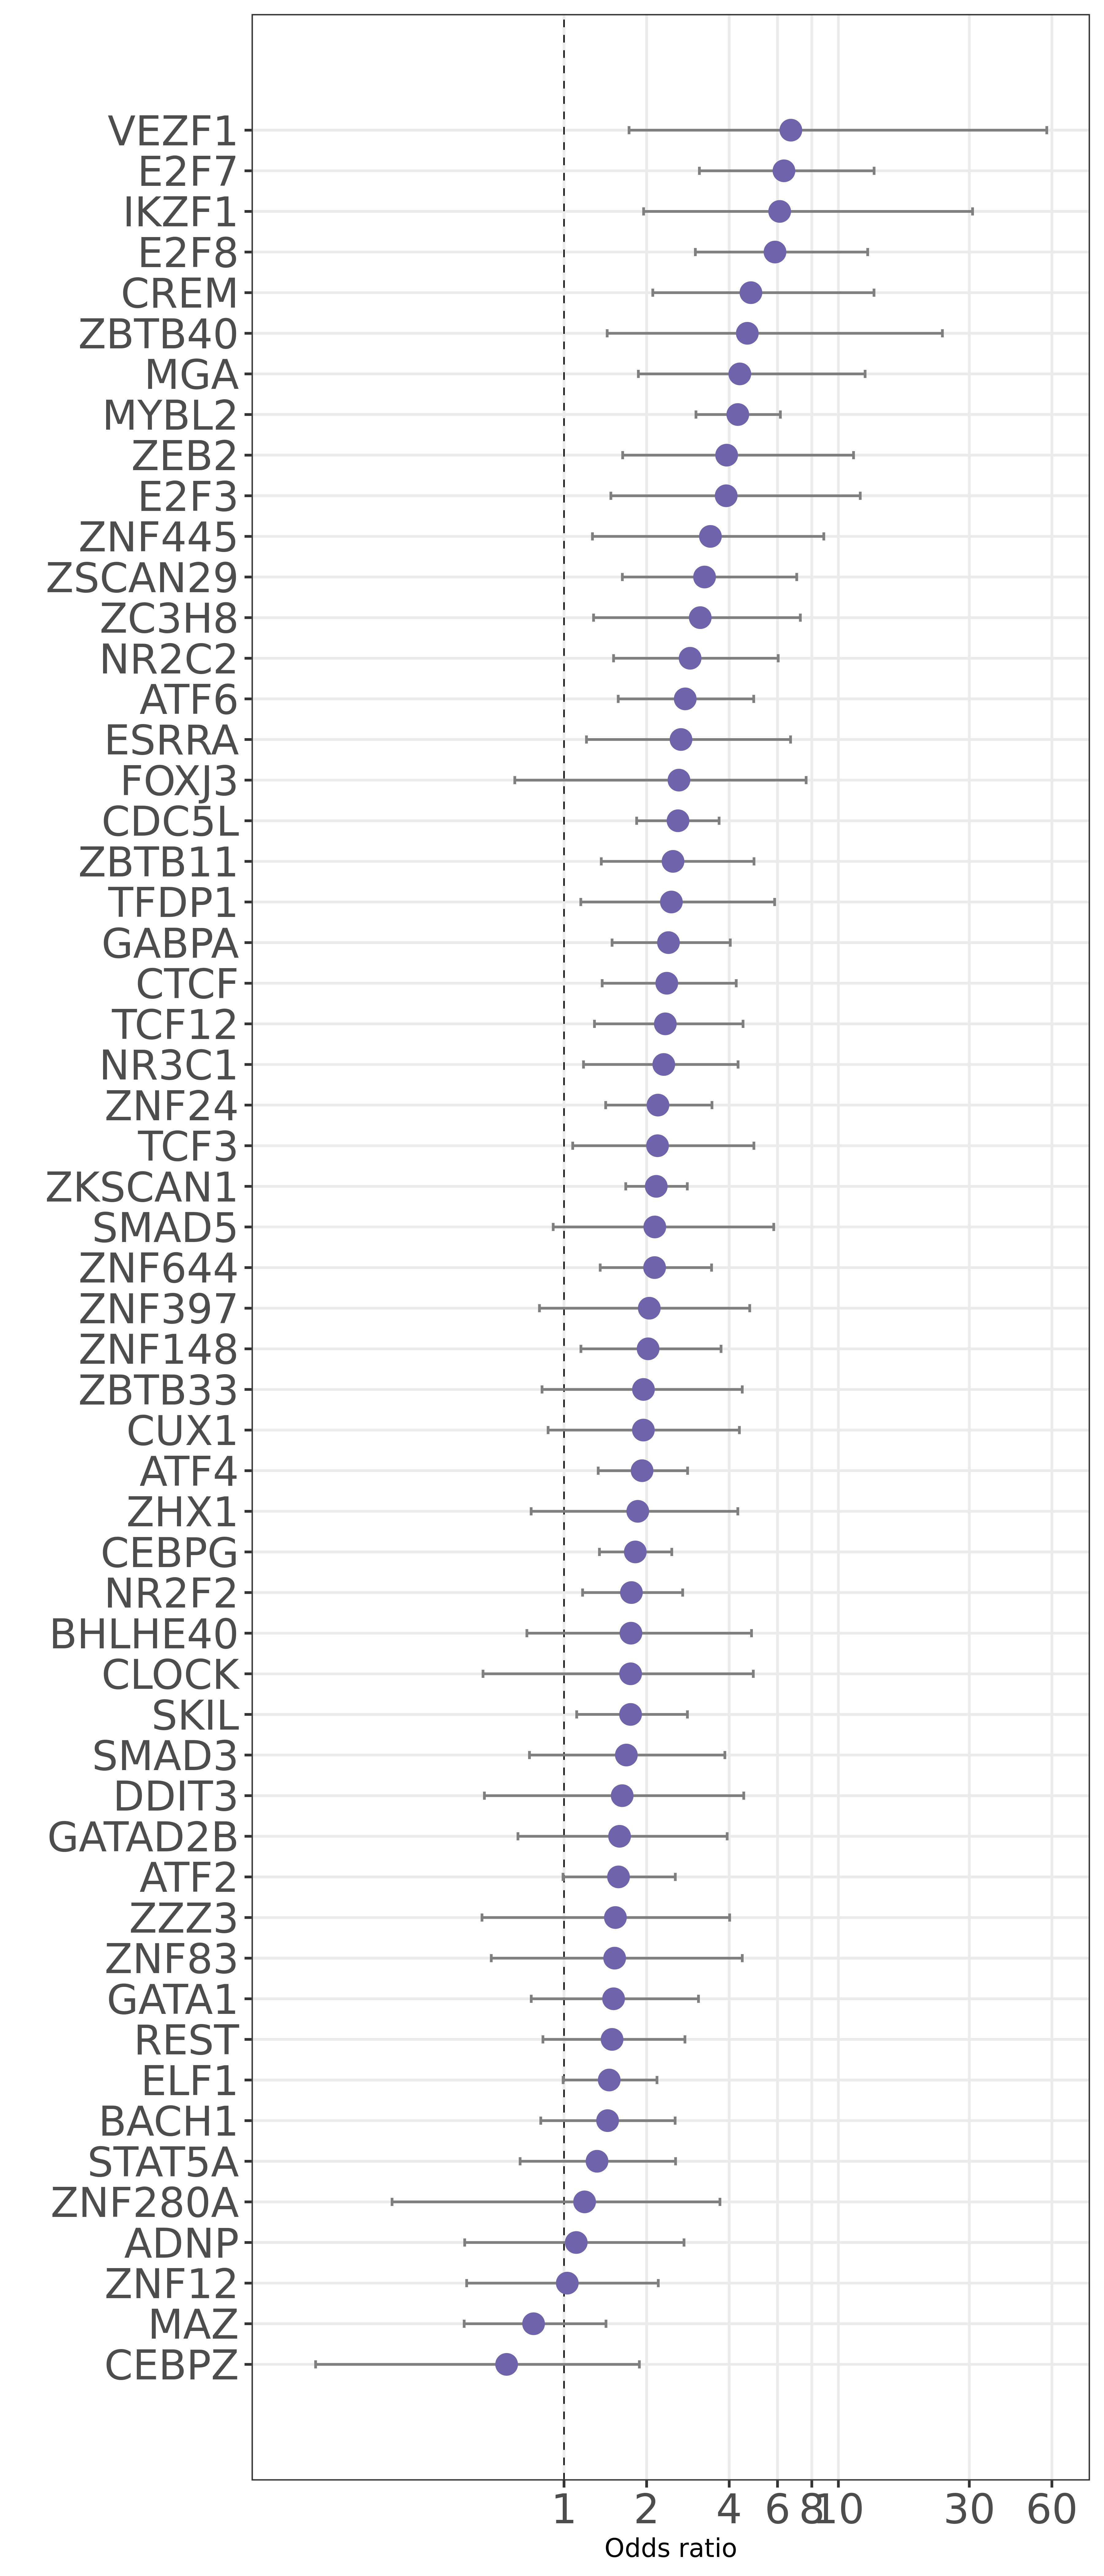

In [33]:
options(repr.plot.width = 6, repr.plot.height = 14)

p <- ggplot(df, aes(x = boxOdds, y = yAxis))
p + geom_vline(aes(xintercept = 1), size = .25, linetype = "dashed") +
  geom_errorbar(aes(xmax = boxCIHigh, xmin = boxCILow), size = .5, width = .2, color = "gray50") +
  geom_point(size = 3.5, color = "#6F63AC") +
  theme_bw() +
  theme(panel.grid.minor = element_blank()) +
  scale_y_continuous(breaks = df$yAxis, labels = boxLabels) +
  scale_x_continuous(breaks = c(1,2,4,6,8,10,30,60), limits=c(0.1,60)) +
  coord_trans(x = "log10") +
  ylab("") +
  xlab("Odds ratio") +theme(axis.text=element_text(size=16),
                                          axis.title=element_text(size=10))